### Курсовой по предмету "Библиотеки Python для Data Science"

Задача: предсказать цены на квартиры в датасете test.csv. Даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки). 
Целевая переменная: Price. 
Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

In [1]:
import numpy as np
import pandas as pd
import pickle   # сохранение модели
import random

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
#from catboost import CatBoostRegressor

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [3]:
# Пути к файлам

TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Загрузка данных

In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.set_index('Id', inplace=True) # установил АйДи как индекс датафрейма
train_df.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272
13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191
9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732


In [6]:
train_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.set_index('Id', inplace=True)
test_df.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
868,38,3.0,87.139994,53.180419,10.0,4,23.0,2011,0.060753,B,B,15,2787,2,520.0,0,7,B
672,62,1.0,46.269456,22.820239,11.0,8,17.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A
2471,2,2.0,48.172969,29.924204,6.0,4,9.0,1974,0.000000,B,B,33,7425,1,NaN,2,5,B
4510,1,1.0,43.153761,21.017596,9.0,10,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B


In [8]:
print(f"В Train\t{train_df.shape[0]}\t строк и {train_df.shape[1]} фичей")
print(f'В Test\t{test_df.shape[0]}\t строк и {test_df.shape[1]} фичей')

В Train	10000	 строк и 19 фичей
В Test	5000	 строк и 18 фичей


In [9]:
test_df.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

### Приведение типов. Обработка категориальных признаков

In [10]:
# DistrictId вместо int надо сделать строковым
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

# Значения в 'Ecology_2', 'Ecology_3', 'Shops_2' надо вместо А и В сделать числовыми - 0 или 1
feature_bins = ['Ecology_2', 'Ecology_3', 'Shops_2']

train_df[feature_bins] = train_df[feature_bins].replace({'A':0, 'B':1})
test_df[feature_bins] = test_df[feature_bins].replace({'A':0, 'B':1})

train_df.dtypes

DistrictId        object
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2          int64
Ecology_3          int64
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2            int64
Price            float64
dtype: object

### Обработка пропусков 

In [11]:
train_df.isna().sum()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [12]:
train_df.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,NaN,0,0,1,305018.871089
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.553407
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.720850
2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,168106.007630
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,NaN,0,6,1,343995.102962
5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,1,1,35,5776,1,2078.0,2,4,1,161044.944138
8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,1,1,24,4860,1,80.0,0,3,1,142402.739272
13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,1,1,37,7687,11,176.0,5,5,1,326174.175191
9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,1,1,1,264,0,NaN,0,1,1,160400.401732


В LifeSquare и Healthcare_1 много пропусков, отсутствующие LifeSquare (жилые пространства) можно заполнить разницей общей площади и площади кухни, а Healthcare_1 медианами.

In [13]:
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = test_df['Square'] - test_df['KitchenSquare']

train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].median()
test_df.loc[test_df['Healthcare_1'].isna(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

train_df.isna().sum()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [14]:
train_df.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,105.027311,10.0,4,10.0,2014,0.075424,1,1,11,3097,0,900.0,0,0,1,305018.871089
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.553407
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.720850
2352,1,1.0,40.409907,39.409907,1.0,10,22.0,1977,0.007122,1,1,1,264,0,900.0,0,1,1,168106.007630
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,1,1,33,8667,2,900.0,0,6,1,343995.102962
5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,1,1,35,5776,1,2078.0,2,4,1,161044.944138
8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,1,1,24,4860,1,80.0,0,3,1,142402.739272
13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,1,1,37,7687,11,176.0,5,5,1,326174.175191
9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,1,1,1,264,0,900.0,0,1,1,160400.401732


### Обработка выбросов
#### Rooms

In [15]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,41.799474,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,0.917500,214138.857399
std,0.839512,21.058732,77.823543,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,0.275139,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,25.494155,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,1.000000,153872.633942
50%,2.000000,52.513310,37.040829,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,2.000000,65.900625,49.823229,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,1.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


In [16]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

0 комнат - выброс; также будем считать и про 6, 10 и 19 комнат; заменим модами

In [17]:
train_df.loc[(train_df['Rooms'] > 5)|(train_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].mode()[0]
test_df.loc[(test_df['Rooms'] > 5)|(test_df['Rooms'] == 0), 'Rooms'] = test_df['Rooms'].mode()[0]

train_df['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### Square, LifeSquare, KitchenSquare

In [18]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000
mean,56.315775,41.799474,6.273300
std,21.058732,77.823543,28.560917
min,1.136859,0.370619,0.000000
25%,41.774881,25.494155,1.000000
50%,52.513310,37.040829,6.000000
75%,65.900625,49.823229,9.000000
max,641.065193,7480.592129,2014.000000


In [19]:
train_df.nlargest(10, 'Square')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,1,1,22,6398,141,1046.0,3,23,1,133529.681562
28,9,2.0,604.705972,603.705972,1.0,17,18.0,1977,0.161532,1,1,25,5648,1,30.0,2,4,1,187717.242538
2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,1,1,26,3889,6,705.0,3,6,1,90470.430830
5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,1,0,31,7010,5,4508.0,3,7,1,455264.882666
7917,27,2.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,1,1,9,1892,0,900.0,0,1,1,302211.260887
16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,1,1,53,14892,4,900.0,1,4,1,528560.506016
4249,23,5.0,198.930182,123.139863,10.0,1,2.0,2011,0.014073,1,1,2,475,0,900.0,0,0,1,345665.209100
3718,56,3.0,190.857689,107.376164,19.0,7,3.0,2007,0.000000,1,1,23,5067,4,900.0,2,6,1,338644.075979
3233,129,4.0,186.692602,87.487080,32.0,3,3.0,2011,0.020741,1,1,24,5613,5,1340.0,2,5,1,423443.464367


In [20]:
train_df.nsmallest(15, 'Square')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,1,1,1,264,0,900.0,0,1,1,181434.825589
15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,1,1,53,13670,4,900.0,1,11,1,458378.777006
3224,27,2.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,1,1,2,469,0,900.0,0,0,1,126596.941798
10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,1,1,5,1564,0,540.0,0,0,1,137597.601458
6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,1,1,23,5212,6,900.0,3,2,1,438005.182323
10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,1,1,9,1892,0,900.0,0,1,1,97560.720383
4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,1,1,9,1892,0,900.0,0,1,1,161379.067034
7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,1,1,15,2787,2,520.0,0,7,1,483283.488083
11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,1,1,4,915,0,900.0,0,0,1,107604.269441


In [21]:
# Там где общ. площадь больше 300 (это всего 3 объекта), а также менее 15 квадратов - буду считать выброс; туда воткну медианы

train_df.loc[(train_df['Square'] > 300) | (train_df['Square'] < 15), 'Square'] = train_df['Square'].median()
test_df.loc[(test_df['Square'] > 300) | (test_df['Square'] < 15), 'Square'] = test_df['Square'].median()

# В таблицах выше видно и неадекватные значения 'LifeSquare':
# тут возьму меньше 15 квадратов и больше 250-ти, но вставлю не медианы, а приравняю к просто площади

train_df.loc[(train_df['LifeSquare'] > 250) | (train_df['LifeSquare'] < 15), 'LifeSquare'] = train_df['Square']
test_df.loc[(test_df['LifeSquare'] > 250) | (test_df['LifeSquare'] < 15), 'LifeSquare'] = test_df['Square']

# По поводу площади кухонь - значения менее 4 квадратов сделаю равными 4 квадратам, а там, 
# где площадь кухни больше жилой площади - равной медиане по 'KitchenSquare' 

train_df.loc[train_df['KitchenSquare'] < 4, 'KitchenSquare'] = 4
train_df.loc[train_df['KitchenSquare'] > train_df['LifeSquare'], 'KitchenSquare'] = train_df['KitchenSquare'].median()
test_df.loc[test_df['KitchenSquare'] < 4, 'KitchenSquare'] = 4
test_df.loc[test_df['KitchenSquare'] > test_df['LifeSquare'], 'KitchenSquare'] = test_df['KitchenSquare'].median()

train_df.nlargest(10, 'Square')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,1,0,31,7010,5,4508.0,3,7,1,455264.882666
7917,27,2.0,212.932361,211.231125,4.0,2,3.0,2008,0.211401,1,1,9,1892,0,900.0,0,1,1,302211.260887
16568,27,4.0,200.334539,201.627361,25.0,1,2.0,2013,0.041116,1,1,53,14892,4,900.0,1,4,1,528560.506016
4249,23,5.0,198.930182,123.139863,10.0,1,2.0,2011,0.014073,1,1,2,475,0,900.0,0,0,1,345665.209100
3718,56,3.0,190.857689,107.376164,19.0,7,3.0,2007,0.000000,1,1,23,5067,4,900.0,2,6,1,338644.075979
3233,129,4.0,186.692602,87.487080,32.0,3,3.0,2011,0.020741,1,1,24,5613,5,1340.0,2,5,1,423443.464367
15947,129,4.0,185.906396,84.830074,31.0,5,3.0,2015,0.020741,1,1,24,5613,5,1340.0,2,5,1,340273.238253
13434,13,5.0,183.382273,100.985505,15.0,2,6.0,1997,0.090799,1,1,74,19083,2,900.0,5,15,1,622888.825328
11055,151,1.0,174.649522,174.837082,15.0,10,12.0,1958,0.236108,1,1,16,3893,27,900.0,3,10,1,232766.187698


In [22]:
len(train_df[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'])])
# нужно избавиться от случаев, когда площадь общая оказалась меньше чем сумма жилой и площади кухни, приравняв её к этой сумме

3375

In [23]:
len(test_df[(test_df['Square'] < test_df['LifeSquare'] + test_df['KitchenSquare'])])

1677

In [24]:
train_df.loc[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare']), 'Square'] = train_df['LifeSquare'] + train_df['KitchenSquare']
test_df.loc[(test_df['Square'] < test_df['LifeSquare'] + test_df['KitchenSquare']), 'Square'] = test_df['LifeSquare'] + test_df['KitchenSquare']

len(train_df[(train_df['Square'] < train_df['LifeSquare'] + train_df['KitchenSquare'])])

0

In [25]:
len(test_df[(test_df['Square'] < test_df['LifeSquare'] + test_df['KitchenSquare'])])

0

In [26]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000
mean,57.709449,42.086547,6.834300
std,19.812120,19.998709,3.906862
min,19.170851,15.001234,4.000000
25%,43.183819,27.762436,4.000000
50%,53.831300,38.334514,6.000000
75%,68.135668,50.995335,9.000000
max,275.645284,233.949309,123.000000


#### Floor, HouseFloor

In [27]:
# теперь смотрим на этажность здания (есть ноль этажей, либо слишком много этажей) и этаж квартиры, 
# а также на примеры, когда квартира на этаже выше этажности здания

train_df.nlargest(10, 'HouseFloor')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
78,30,2.0,70.811789,66.811789,4.0,8,117.0,1977,0.000078,1,1,22,6398,141,1046.0,3,23,1,207248.370520
9300,74,2.0,83.579809,74.579809,9.0,5,99.0,1977,0.075779,1,1,6,1437,3,900.0,0,2,1,243329.912579
10806,5,1.0,52.709601,48.709601,4.0,6,99.0,1977,0.150818,1,1,16,3433,4,2643.0,4,5,1,296127.115515
1674,76,2.0,74.344672,41.044132,5.0,42,48.0,2016,0.000000,1,1,7,1660,39,1786.0,1,5,1,411691.504766
7453,24,3.0,126.621358,62.455481,12.0,22,48.0,2011,0.111627,1,1,50,12238,8,1970.0,2,3,1,179396.521035
6502,20,1.0,126.389517,103.637322,14.0,22,47.0,2012,0.019509,1,1,37,7687,11,176.0,5,5,1,450706.552655
5279,93,2.0,60.804544,30.923827,11.0,5,45.0,2016,0.050900,1,1,43,10621,1,30.0,2,3,1,213171.135199
6589,30,1.0,62.110823,52.812128,4.0,31,44.0,2009,0.000078,1,1,22,6398,141,1046.0,3,23,1,117647.461002
7496,30,1.0,117.370746,102.187199,6.0,14,40.0,2011,0.000078,1,1,22,6398,141,1046.0,3,23,1,521829.550445


In [28]:
train_df.nsmallest(10, 'HouseFloor')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
4717,27,1.0,48.203947,44.203947,4.0,2,0.0,1977,0.072158,1,1,2,629,1,900.0,0,0,0,135466.559958
12947,53,2.0,60.023342,56.023342,4.0,14,0.0,1977,0.049637,1,1,34,7759,0,229.0,1,3,1,247074.564832
13146,74,1.0,50.449711,46.449711,4.0,6,0.0,1977,0.075779,1,1,6,1437,3,900.0,0,2,1,168705.450148
12174,62,1.0,48.954880,44.954880,4.0,8,0.0,1977,0.072158,1,1,2,629,1,900.0,0,0,0,133773.301722
15661,45,3.0,85.094922,81.094922,4.0,15,0.0,1977,0.195781,1,1,23,5212,6,900.0,3,2,1,442472.456032
6812,27,1.0,45.728985,41.728985,4.0,11,0.0,1977,0.011654,1,1,4,915,0,900.0,0,0,1,112236.131647
1539,6,2.0,59.084228,55.084228,4.0,12,0.0,1977,0.243205,1,1,5,1564,0,540.0,0,0,1,146456.645948
10636,27,2.0,63.734454,59.734454,4.0,5,0.0,1977,0.211401,1,1,9,1892,0,900.0,0,1,1,149782.292547
13113,27,1.0,48.805231,37.805231,11.0,6,0.0,2015,0.017647,1,1,2,469,0,900.0,0,0,1,137402.092529


In [29]:
len(train_df[(train_df['HouseFloor'] == 0)])

269

In [30]:
len(test_df[(test_df['HouseFloor'] == 0)])

131

In [31]:
len(train_df[(train_df['Floor'] == 0)])

0

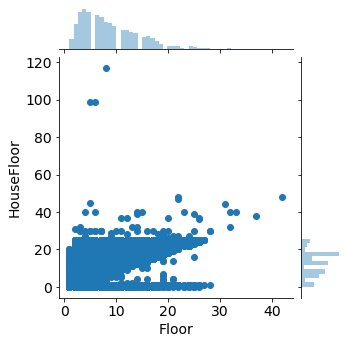

In [32]:
sns.jointplot(train_df['Floor'], train_df['HouseFloor'], kind='scatter', height=5);

In [33]:
train_df[train_df['Floor'] > train_df['HouseFloor']]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,1,0,26,4439,1,1130.0,1,5,1,186971.926566
367,45,1.0,44.012529,40.012529,4.0,16,14.0,2015,0.195781,1,1,23,5212,6,900.0,3,2,1,250466.980777
8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,1,1,37,7687,11,176.0,5,5,1,366916.246494
4717,27,1.0,48.203947,44.203947,4.0,2,0.0,1977,0.072158,1,1,2,629,1,900.0,0,0,0,135466.559958
4521,6,2.0,68.409965,64.409965,4.0,18,1.0,1977,0.243205,1,1,5,1564,0,540.0,0,0,1,191205.272608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16258,48,3.0,102.152802,98.152802,4.0,15,1.0,2017,0.041125,1,1,46,9515,5,900.0,1,10,1,524365.550705
9920,1,3.0,89.487550,85.487550,4.0,18,17.0,1977,0.007122,1,1,1,264,0,900.0,0,1,1,248248.935528
13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,1,1,5,1564,0,540.0,0,0,1,114878.830713


In [34]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]
train_df.loc[train_df['HouseFloor'] > 49, 'HouseFloor'] = train_df['HouseFloor'].mode()[0]

test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].mode()[0]
test_df.loc[test_df['HouseFloor'] > 49, 'HouseFloor'] = test_df['HouseFloor'].mode()[0]

In [35]:
train_df[['Floor', 'HouseFloor']].describe()

,Floor,HouseFloor
count,10000.000000,10000.000000
mean,8.526700,13.040300
std,5.241148,6.276338
min,1.000000,1.000000
25%,4.000000,9.000000
50%,7.000000,14.000000
75%,12.000000,17.000000
max,42.000000,48.000000


In [36]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = train_df['HouseFloor']
test_df.loc[test_df['Floor'] > test_df['HouseFloor'], 'Floor'] = test_df['HouseFloor']

In [37]:
len(train_df[train_df['Floor'] > train_df['HouseFloor']])

0

#### HouseYear

In [38]:
train_df.nlargest(5, 'HouseYear')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265070,20.239714,9.0,9.0,12.0,20052011,0.136330,1,1,30,6141,10,262.0,3,6,1,254084.534396
11607,147,2.0,44.791836,28.360393,5.0,4.0,9.0,4968,0.319809,1,1,25,4756,16,2857.0,5,8,1,243028.603096
6731,120,2.0,87.976325,77.976325,10.0,7.0,10.0,2020,0.341072,1,1,27,5664,48,2300.0,3,11,1,536020.260344
8433,45,2.0,88.512719,84.512719,4.0,19.0,22.0,2020,0.195781,1,1,23,5212,6,900.0,3,2,1,441850.464440
13914,23,3.0,74.222388,44.992259,13.0,3.0,3.0,2020,0.005767,1,1,1,388,0,900.0,0,0,1,106209.372321


In [39]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020
test_df.loc[test_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [40]:
train_df.nlargest(5, 'HouseYear')

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
6731,120,2.0,87.976325,77.976325,10.0,7.0,10.0,2020,0.341072,1,1,27,5664,48,2300.0,3,11,1,536020.260344
8433,45,2.0,88.512719,84.512719,4.0,19.0,22.0,2020,0.195781,1,1,23,5212,6,900.0,3,2,1,441850.464440
13914,23,3.0,74.222388,44.992259,13.0,3.0,3.0,2020,0.005767,1,1,1,388,0,900.0,0,0,1,106209.372321
14318,53,2.0,57.815313,37.287063,8.0,6.0,24.0,2020,0.049637,1,1,34,7759,0,229.0,1,3,1,251249.365740
9303,53,2.0,57.126663,40.265100,10.0,11.0,24.0,2020,0.049637,1,1,34,7759,0,229.0,1,3,1,263206.223152


### Отбор признаков

In [41]:
train_df.columns.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [42]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']
target_name = 'Price'

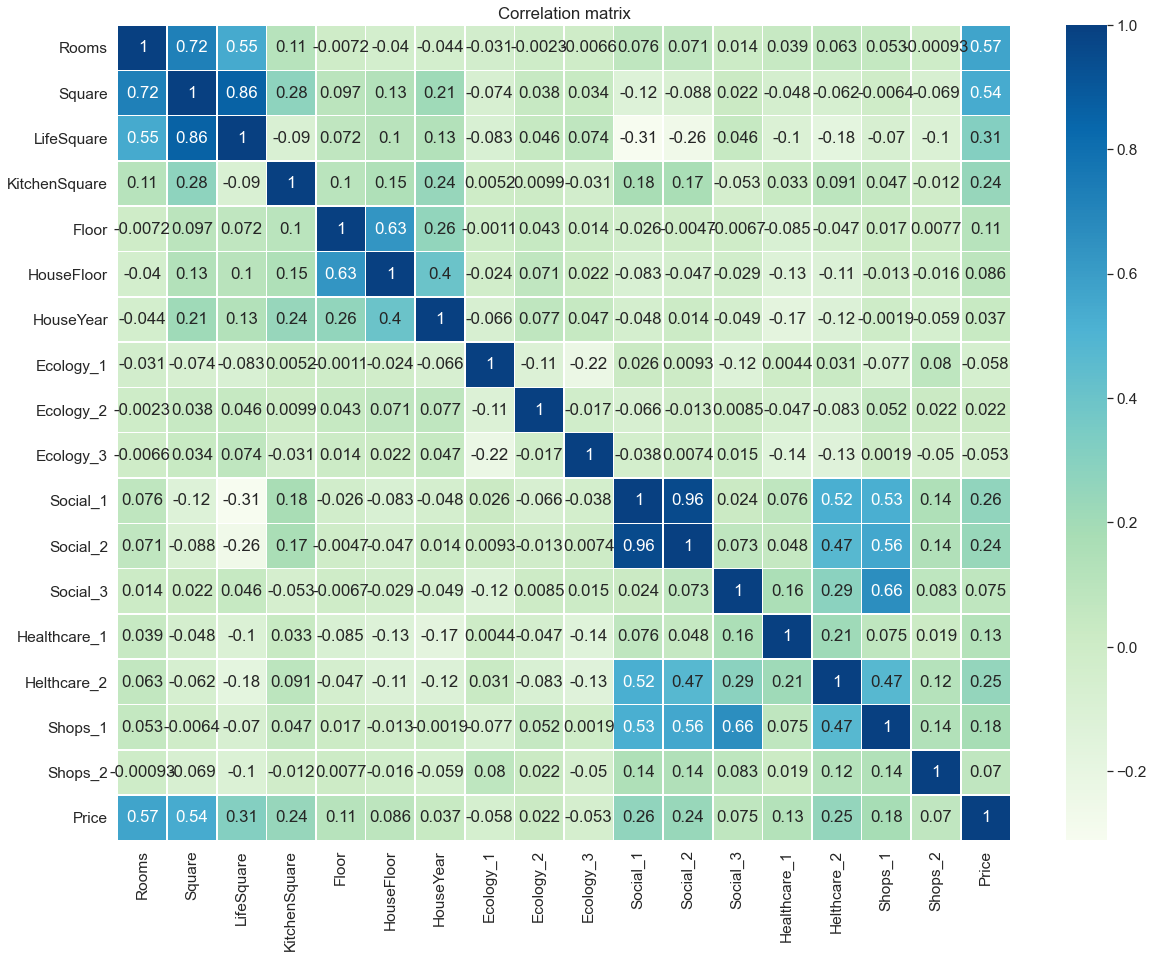

In [43]:
plt.figure(figsize=(20,15))

sns.set(font_scale=1.4)
sns.heatmap(train_df[feature_names + ['Price']].corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Построение и оценка модели

In [44]:
X = train_df[feature_names]
y = train_df[target_name]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)

In [46]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

Train R2:	0.961
Test R2:	0.743


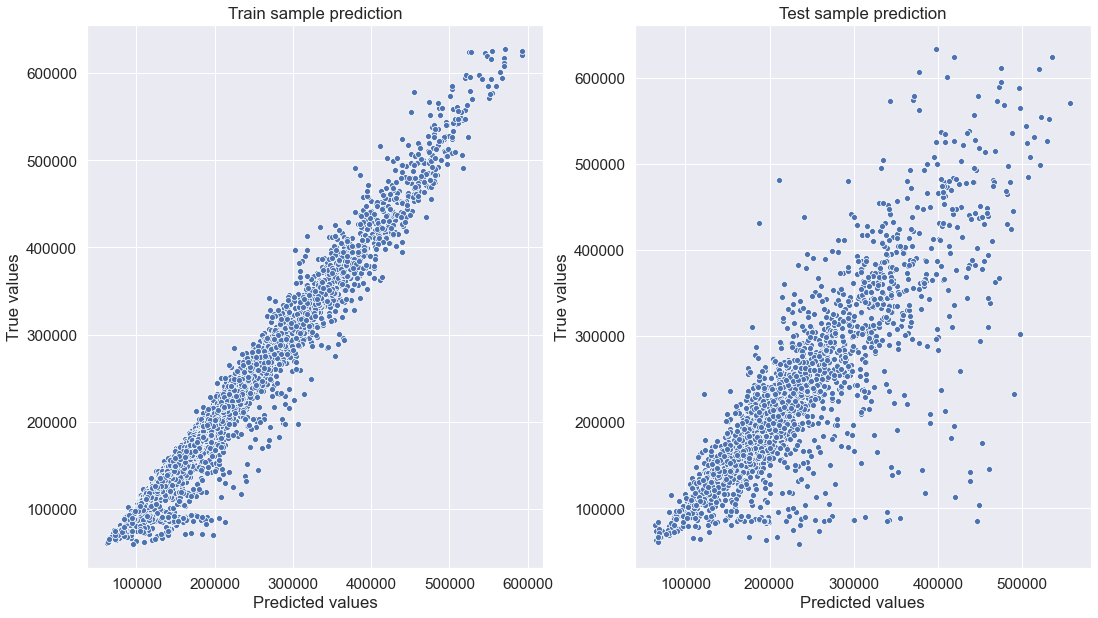

In [47]:

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [48]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.65687712, 0.6909323 , 0.75175079])

In [49]:
cv_score.mean()

0.6998534038056095

### Важность признаков

In [73]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.291188
1,Rooms,0.167078
12,Social_2,0.094337
11,Social_1,0.082700
13,Social_3,0.072553
0,DistrictId,0.064776
8,Ecology_1,0.046713
7,HouseYear,0.036807
3,LifeSquare,0.033570
4,KitchenSquare,0.028892


### Прогнозирование

In [50]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [51]:
predictions = rf_model.predict(test_df)
predictions

array([158005.9372297 , 132092.55773831, 142550.13157467, ...,
       145072.87327623, 193991.33716168, 281934.06081176])

In [52]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,158005.937230
1,5925,132092.557738
2,960,142550.131575
3,3848,135587.315163
4,746,295291.341624


In [53]:
submit.to_csv('rf_submit.csv', index=False)